In [ ]:
import sys
sys.path.append("../..")

import numpy as np
from emlopt import solvers, surrogates
from emlopt.utils import set_seed,  is_plot_visible, min_max_scale_in, min_max_restore_out, timer
from emlopt.problem import build_problem
from experiments.problems.simple_functions import polynomial, build_rosenbrock, mccormick

import logging
def create_logger(name):
    test_logger = logging.getLogger(name)
    stream = logging.StreamHandler(sys.stdout)
    stream.setFormatter(logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s'))
    if not test_logger.handlers:
        test_logger.addHandler(stream)
    test_logger.setLevel(logging.DEBUG)
    test_logger.propagate = False
    return test_logger
logger = create_logger('sigma-loss')


In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_probability as tfp
from emlopt.surrogates.base_surrogate import BaseSurrogate
from emlopt.utils import min_max_scale_in, min_max_scale_out
import matplotlib.pyplot as plt
import tempfile
import math

def build_probabilistic_regressor(input_shape, depth=4, width=20):
    inp = tf.keras.layers.Input(shape=(input_shape + 1,), dtype='float32') 
    x = inp
    for i in range(depth):
        x = tf.keras.layers.Dense(width, activation='relu')(x)
    y = tf.keras.layers.Dense(1, activation='linear')(x)
    return tf.keras.Model(inputs=inp, outputs=y)

def gauss_density_centered(x, std):
    return tf.math.exp(-0.5*(x / std)**2) / (math.sqrt(2*math.pi)*std)

def gmm_density_centered(x, std):
    """
    Assumes dim=-1 is the component dimension and dim=-2 is feature dimension. Rest are sample dimension.
    """
    if len(x.shape) == len(std.shape) - 1:
        x = tf.expand_dims(x, axis=-1)
    elif not (x.shape == std.shape and x.shape[-1] == 1):
        raise ValueError('Last dimension must be the gmm stds.')
    return tf.math.reduce_mean(tf.math.reduce_prod(gauss_density_centered(x, std), axis=-2), axis=-1)

def sample_gmm_centered(std, num_samples=1):
    num_components = std.shape[-1]
    num_dims = tf.size(std) // num_components

    std = tf.reshape(std, (1, num_dims, num_components))

    # Sample component ids
    k = tf.random.uniform((num_samples,), maxval=num_components, dtype=tf.int64)
    std_samp = tf.gather(std[0,:], k, axis=1)
    std_samp = tf.reshape(std_samp, (num_samples, num_dims))
    
    # Sample
    x_centered = std_samp * tf.random.normal((num_samples, num_dims))
    prob_dens = gmm_density_centered(x_centered, std)
    
    prob_dens_zero = gmm_density_centered(tf.zeros_like(x_centered), std)

    return x_centered, prob_dens, prob_dens_zero

def shuffle_dataset(dataset_x, dataset_y):
    dataset_y = np.expand_dims(dataset_y, axis=-1)
    concatenated = np.concatenate((dataset_x,dataset_y), axis=-1)
    np.random.shuffle(concatenated)
    return concatenated[:,:dataset_x.shape[1]], concatenated[:,-1]

In [153]:
def energy_loss(x, y, keras_mdl):
    # x shape: (batch_size, 1)
    y = tf.cast(tf.expand_dims(y, axis=-1), dtype=tf.float32) # (shape: (batch_size, 1))
    inp = tf.concat([x, y], -1)
    scores = keras_mdl(inp) # shape: (batch_size, 1)
    
    batch_size = x.shape[0]
    num_samples = 1024
    stds = tf.zeros((1, 2)) + [0.1, 0.8]
    scores_gt = tf.squeeze(scores) # (shape: (batch_size))

    y_samples_zero, q_y_samples, q_ys = sample_gmm_centered(stds, num_samples=num_samples)
    y_samples_zero = tf.squeeze(y_samples_zero, axis=1) # (shape: (num_samples))
    y_samples = y + tf.expand_dims(y_samples_zero, axis=0) # (shape: (batch_size, num_samples))
    
    q_y_samples = tf.expand_dims(q_y_samples, axis=0)*tf.ones(y_samples.shape) # (shape: (batch_size, num_samples))
    q_ys = q_ys[0]*tf.ones(x.shape[0]) # (shape: (batch_size))
    
    # print("x",x)
    x_repeated = tf.repeat(x, repeats=[num_samples], axis=0)
    # print("x repeated",x_repeated)
    x_repeated = tf.cast(tf.reshape(x_repeated, (batch_size*num_samples, x.shape[1])), tf.float32)
    # print("x reshaped",x_repeated)
    
    # print("y",y_samples)
    y_repeated = tf.cast(tf.reshape(y_samples, (batch_size*num_samples, 1)), tf.float32)
    # print("y_repeated", y_repeated)

    inp2 = tf.concat([x_repeated, y_repeated], -1)
    scores_samples = keras_mdl(inp2)
    scores_samples = tf.reshape(scores_samples, (batch_size, num_samples)) # (shape: (batch_size, num_samples))
    
    loss = - tf.math.reduce_mean(
        scores_gt - tf.math.log(q_ys) - tf.math.log(
            tf.math.exp(scores_gt - tf.math.log(q_ys)) + 
            tf.math.reduce_sum(tf.math.exp(
                scores_samples - tf.math.log(q_y_samples)), axis=1)))


    # print("==============================")
    # print(scores_gt)
    # print(keras_mdl.layers[3].weights)
    # print(keras_mdl.layers[4].weights)
    # print(keras_mdl.layers[5].weights)
    # print(keras_mdl.layers[6].weights)
    # print(keras_mdl.layers[7].weights)
    # print(q_ys)
    # print(q_y_samples)
    # print("==============================")

    return loss

In [152]:
class EBM(BaseSurrogate):

    def __init__(self, *args, **kwargs):
        super(EBM, self).__init__(*args, **kwargs)
        
        
    def plot_loss(self, history):
        plt.plot(history)
        plt.savefig(f'{tempfile.gettempdir()}/train_loss.png')
        if is_plot_visible(): plt.show()
        else: plt.close()

    def plot_predictions(self, keras_mdl, samples_x, samples_y):
        pass

    def fit_surrogate(self, x, y):
        bs = self.batch_size if self.batch_size else x.shape[0]

        y_lb = -1
        y_ub = 1

        norm_x = min_max_scale_in(x, np.array(self.problem.input_bounds))
        norm_y = (y - y_lb) / (y_ub - y_lb)

        # optimizer = tfa.optimizers.AdamW(
        #     weight_decay=self.weight_decay, learning_rate=self.lr)

        optimizer = tf.optimizers.Adam(learning_rate=self.lr)

        keras_mdl = build_probabilistic_regressor(self.problem.input_shape, self.depth, self.width)
                                                                                                       
        history = []
        for epoch in range(self.epochs):
            print("\nStart of epoch %d" % (epoch,))
            bs = min(norm_x.shape[0], self.batch_size)
            norm_x, norm_y = shuffle_dataset(norm_x, norm_y)

            for batch_idx in range(math.ceil(norm_x.shape[0]/bs)):
                if batch_idx == math.ceil(norm_x.shape[0]/bs)-1:
                    batchX = norm_x[batch_idx*bs:]
                    batchY = norm_y[batch_idx*bs:]
                else:
                    batchX = norm_x[batch_idx*bs:(batch_idx+1)*bs]
                    batchY = norm_y[batch_idx*bs:(batch_idx+1)*bs]
                with tf.GradientTape() as tape:
                    loss_value = energy_loss(batchX, batchY, keras_mdl)
                grads = tape.gradient(loss_value, keras_mdl.trainable_weights)
                optimizer.apply_gradients(zip(grads, keras_mdl.trainable_weights))
                
            print("Training loss ", loss_value)
            history.append(loss_value)
            
        self.plot_loss(history)
        
        return keras_mdl


    def plot_predictions(self, keras_mdl, xx, yy):
        num_y_samples = 100
        num_x_samples = 100

        y_lb = -1
        y_ub = 1

        x, ygt = self.problem.get_grid(num_x_samples)
        x_scaled = min_max_scale_in(x, np.array(self.problem.input_bounds))
        # print("x scaled",x)
        x_repeated = tf.repeat(x_scaled, repeats=[num_y_samples], axis=-1)
        # print("x repeated",x_repeated)
        x_repeated = tf.reshape(x_repeated, (num_x_samples*num_y_samples, x_scaled.shape[1]))
        # print("x reshaped",x_repeated)

        y = np.linspace(y_lb, y_ub, num_y_samples)
        #y_samples = min_max_scale_out(y, y)
        y_samples = (y-y_lb) / (y_ub-y_lb)
        y_samples = np.expand_dims(y_samples, axis=0)
        
        y_samples = tf.repeat(y_samples, [num_x_samples], axis=0)
        # print("y repeated", y_samples)
        y_repeated = tf.reshape(y_samples, (num_x_samples*num_y_samples, 1))
        # print("y reshaped", y_repeated)
        # print("concat", tf.concat([x_repeated, y_repeated], -1))

        inp = tf.concat([x_repeated, y_repeated], -1)
        scores_samples = keras_mdl(inp) # (shape: (batch_size, num_samples))
        scores_samples = tf.reshape(scores_samples, (num_x_samples, num_y_samples))
        
        expsum = tf.repeat(tf.expand_dims(tf.math.reduce_sum(tf.math.exp(scores_samples), axis=1), axis=-1), repeats=[num_y_samples], axis=-1)
        probs = tf.math.exp(scores_samples) / expsum
        fig = plt.figure(figsize=(15, 15))
        plt.imshow(np.rot90(probs))
        print(np.max(probs))
        
        maxes = np.argmax(scores_samples, axis=1)
        revy = y_samples[0].numpy()[maxes] * (y_ub - y_lb) + y_lb
        fig = plt.figure(figsize=(15, 10))
        plt.xlim(self.problem.input_bounds[0])
        x = np.squeeze(x)
        plt.scatter(xx, yy)
        plt.plot(x, ygt, c="grey")
        plt.plot(x, revy)

        if is_plot_visible(): plt.show()
        else: plt.close()


Start of epoch 0
Training loss  tf.Tensor(9.256406, shape=(), dtype=float32)

Start of epoch 1
Training loss  tf.Tensor(9.175094, shape=(), dtype=float32)

Start of epoch 2
Training loss  tf.Tensor(9.166364, shape=(), dtype=float32)

Start of epoch 3
Training loss  tf.Tensor(9.084695, shape=(), dtype=float32)

Start of epoch 4
Training loss  tf.Tensor(8.9687, shape=(), dtype=float32)

Start of epoch 5
Training loss  tf.Tensor(8.977842, shape=(), dtype=float32)

Start of epoch 6
Training loss  tf.Tensor(8.786678, shape=(), dtype=float32)

Start of epoch 7
Training loss  tf.Tensor(8.703217, shape=(), dtype=float32)

Start of epoch 8
Training loss  tf.Tensor(8.690426, shape=(), dtype=float32)

Start of epoch 9
Training loss  tf.Tensor(8.556944, shape=(), dtype=float32)

Start of epoch 10
Training loss  tf.Tensor(8.480143, shape=(), dtype=float32)

Start of epoch 11
Training loss  tf.Tensor(8.412402, shape=(), dtype=float32)

Start of epoch 12
Training loss  tf.Tensor(8.318763, shape=(), 

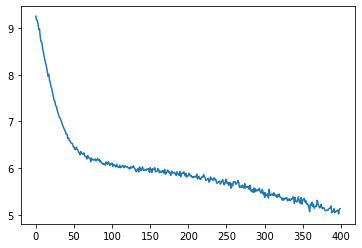

In [156]:
set_seed()

def linear_constraint(backend, model, xvars):
    x=xvars[0]
    return [
        [x<= 0.7 , "center_dist"],
        [x>= 0.3 , "center_dist2"]
    ]

problem = build_problem("polynomial_1D", lambda x: math.sin(x*10)/x/10, ['real'], [[-1,1]])
dataset = problem.get_dataset(200, backend_type='cplex')

X, Y = [], []
for ii, aa in enumerate(dataset[0]):
    if not (aa > -0.5 and aa < 0.5) :
        X.append(aa)
        Y.append(dataset[1][ii])
X = np.stack(X)
Y = np.stack(Y)

surrogate_cfg = {
    "epochs": 400,
    "learning_rate": 5e-3,
    "weight_decay": 0,
    "batch_size": 1024,
    "depth": 2,
    "width": 40,
}

surrogate_model = EBM(problem, surrogate_cfg, logger)
mdl = surrogate_model.fit_surrogate(X,Y)

0.30356348


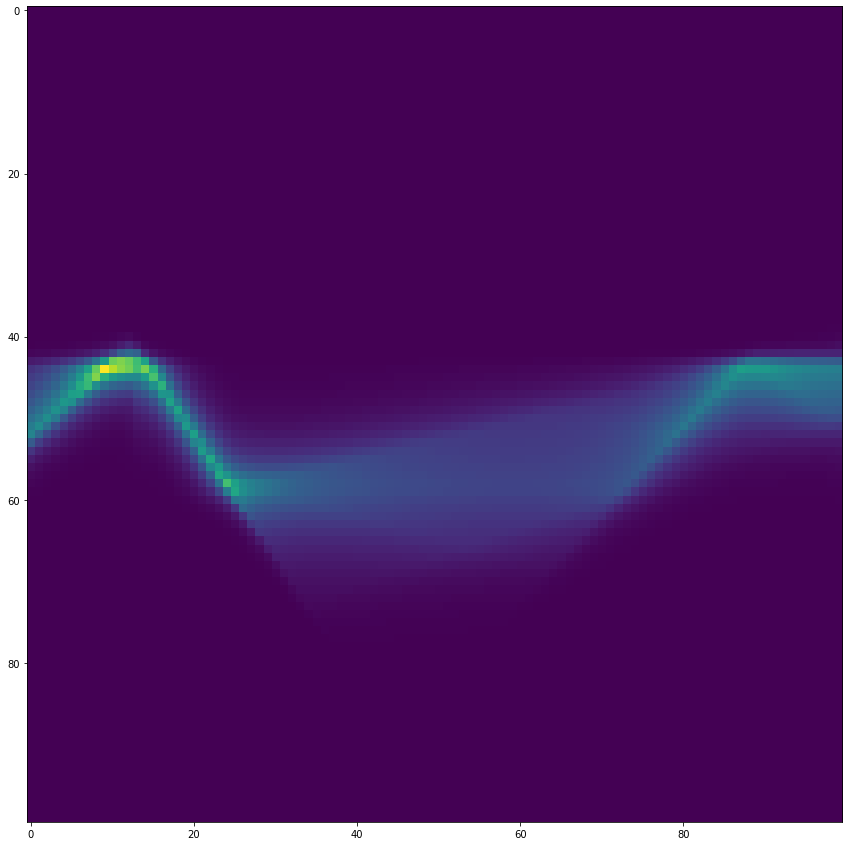

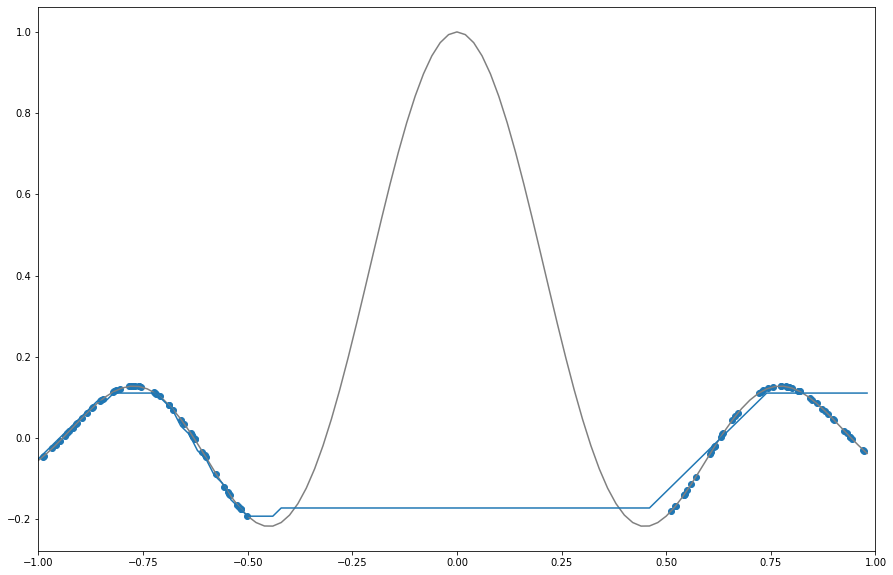

In [157]:
surrogate_model = EBM(problem, surrogate_cfg, logger)
surrogate_model.plot_predictions(mdl, X, Y)